In [73]:
import fitz
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from colorblind import colorblind
import numpy as np
import cv2
import pandas as pd

## Conversión PDF a imagenes

Trabajaremos con el pdf "TestColors.pdf", el cual contiene una tests Ishihara de daltonismo como el siguiente:


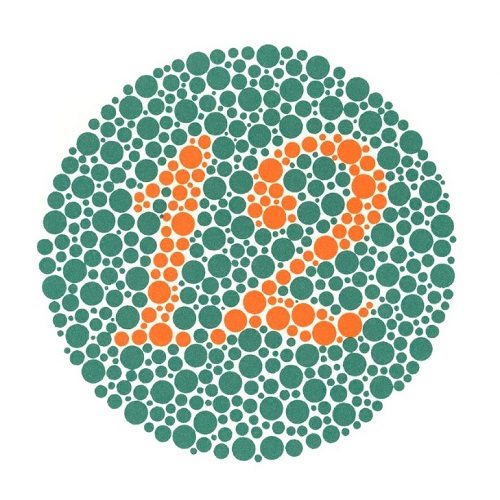


Para trabajar con correción de color, primero es necesario extraer o convertir las imágenes desde un pdf. Para esto construimos una función `pdf_to_png`, la cual toma un pdf y convierte cada página en una imagen.

In [74]:
def pdf_to_png(doc_path, dpi, output, debug = True):
    mat = fitz.Matrix(dpi / 72, dpi / 72)  # sets zoom factor for 1200 dpi
    doc = fitz.open(doc_path)
    #todo: agregar try exception
    for page in tqdm(doc):
        pix = page.get_pixmap(matrix=mat)
        img_filename  = output+"/images/page-%04i.png" % page.number
        if debug:
            print(f"Converted page {page} into {img_filename}")
        pix.pil_save(img_filename, format="PNG", dpi=(dpi,dpi))

In [75]:
pdf_to_png('pdf_test\TestColors.pdf',1200,'output')
#png_to_pdf('output\images',output_path='output\pdf')


  0%|          | 0/1 [00:00<?, ?it/s]

Converted page page 0 of pdf_test\TestColors.pdf into output/images/page-0000.png


100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


Podemos ver que se ha creado una imagen por página del pdf. El pdf tiene 1 página, por lo que se ha creado una imagen.

c:\Users\magda\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (134640000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


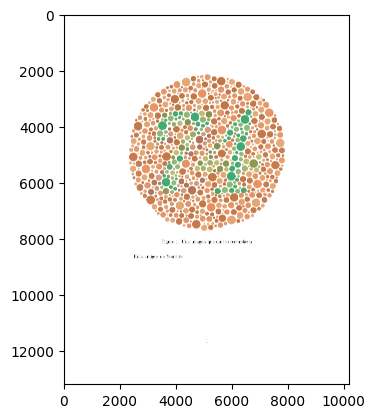

In [76]:
img_creada = Image.open("output\images\page-0000.png")
fig, ax = plt.subplots()
ax.imshow(img_creada)    

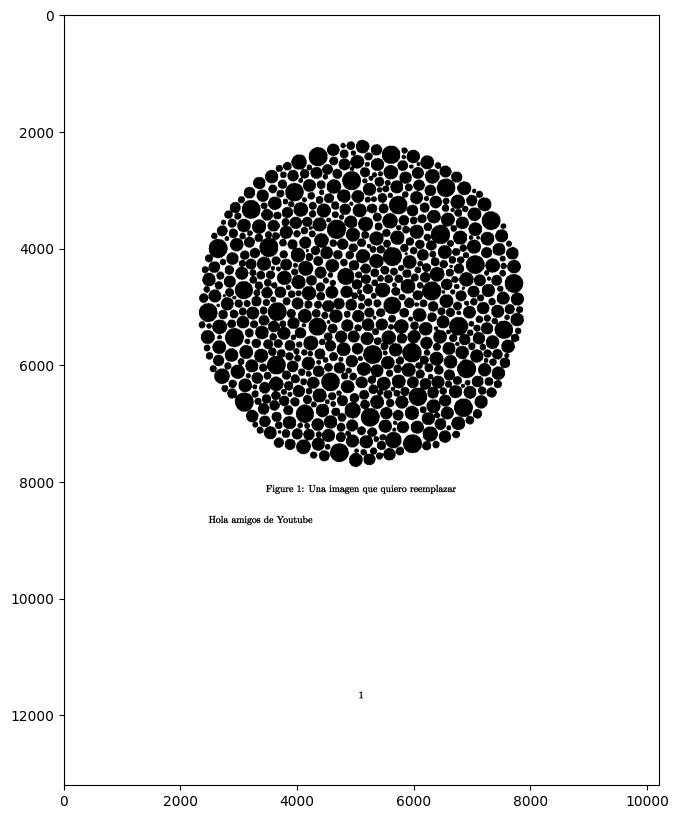

In [86]:
#temp
image = cv2.imread(r'output\images\page-0000.png', cv2.IMREAD_UNCHANGED)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_ , mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
#plt.imshow(gray, cmap = 'gray')
#plt.show()
fig, ax = plt.subplots(figsize = (15,10))
ax.imshow(mask,cmap = 'gray')
plt.show()


c:\Users\magda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


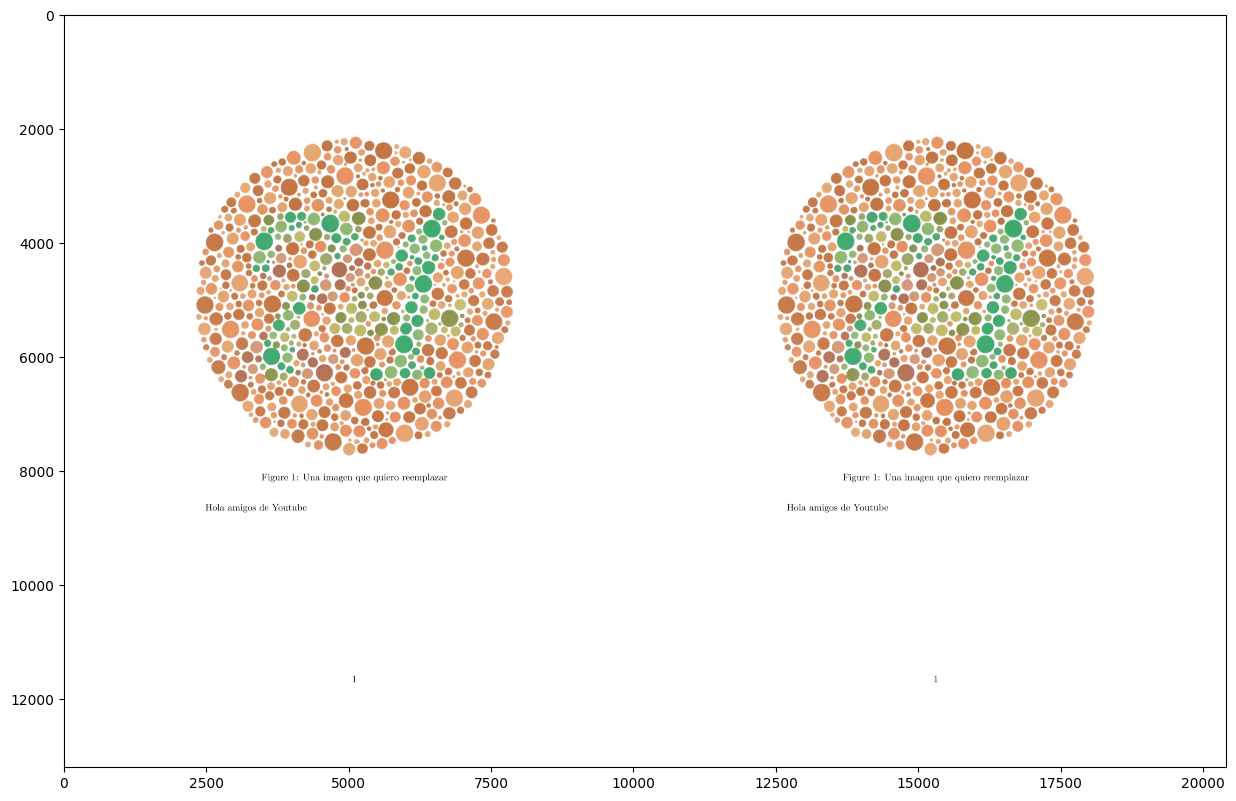

In [87]:
contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    area = int(cv2.contourArea(contour))

    # if area is higher than 3000:
    if area > 3000:
        filtered_contours.append(contour)
        # get mean color of contour:
        masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

from sklearn.cluster import KMeans
km = KMeans( n_clusters=1)
df_mean_color['label'] = km.fit_predict(df_mean_color)

def draw_segmented_objects(image, contours, label_cnt_idx, bubbles_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{bubbles_count} bubbles', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

img = image.copy()
for label, df_grouped in df_mean_color.groupby('label'):
    bubbles_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, bubbles_amount)
    img = cv2.hconcat([img, masked_image])

fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.show()

El número en la imagen debería ser visible para aquellas personas que no presentan daltonismo. Para propositos de esta demostración, simularemos un caso de daltonismo.

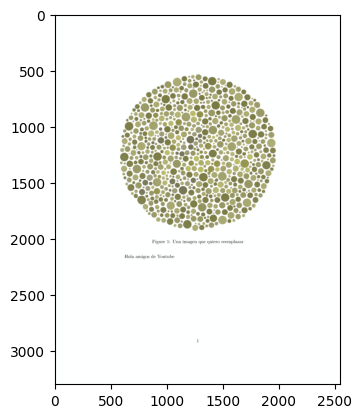

In [ ]:
simulated_img_p = colorblind.simulate_colorblindness(img_creada, colorblind_type = 'protanopia')
fig, ax = plt.subplots()
ax.imshow(simulated_img_p)

Podemos observar que ya no es posible distinguir el número. Esto simula un caso significativo de daltonismo. En realidad, las personas tienen distinta magnitud de percepción a los colores. Pero para efectos de la demostración, es util usar un caso severo. 

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
(3300, 2550, 3)


c:\Users\magda\OneDrive\Escritorio\respos\daltonicont\colorblind_library_copy.py:165: RuntimeWarning: divide by zero encountered in divide
  green_ratio = (hsv_img[..., 0] - (60/360))/rgb_img[..., 1]
c:\Users\magda\OneDrive\Escritorio\respos\daltonicont\colorblind_library_copy.py:166: RuntimeWarning: invalid value encountered in multiply
  blue_range = green_ratio*rgb_img[..., 2]


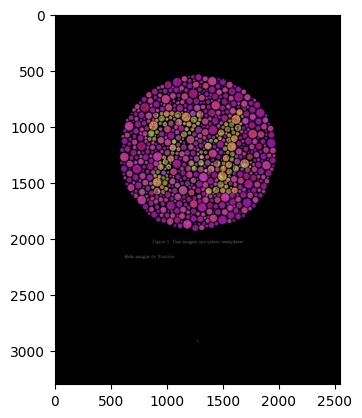

In [ ]:
import colorblind_library_copy
correction = colorblind_library_copy.hsv_color_correct(np.array(img_creada), colorblind_type='protanopia')
fig, ax = plt.subplots()

ax.imshow(correction)

In [ ]:


simulated_img_p = colorblind.simulate_colorblindness(correction, colorblind_type = 'protanopia')
ax.imshow(simulated_img_p)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


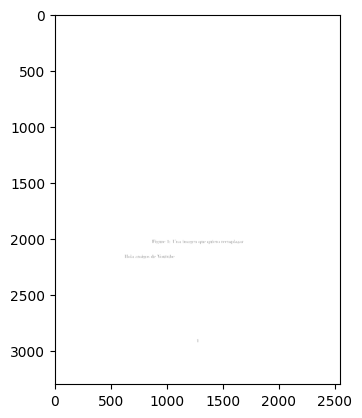

In [ ]:
correction = colorblind.daltonize_correct(np.array(img_creada), colorblind_type='protanopia')
fig, ax = plt.subplots()
ax.imshow(correction)

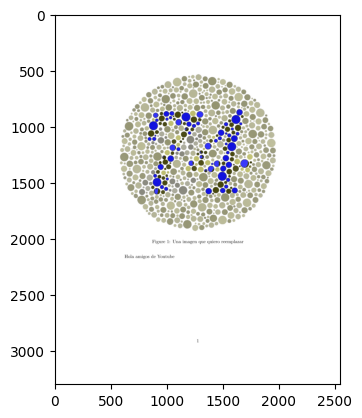

In [ ]:
simulated_img_p = colorblind.simulate_colorblindness(correction, colorblind_type = 'protanopia')
fig, ax = plt.subplots()
ax.imshow(simulated_img_p)


In [ ]:
def png_to_pdf(imgs_path, output_path,encoding = 'RGB'):
    pdf = FPDF()

    path_images = glob.glob(imgs_path+'\\page-*.png') 
    #print(path_images)
   # images_for_pdf = []
   #for image in tqdm(path_images):
      #  img_open = Image.open(image)
      #  img_convert = img_open.convert(encoding)
      #  images_for_pdf.append(img_convert)
       # img_convert.save(imgs_path+'\\archivo.pdf')
    for image in path_images:
        pdf.add_page()
        pdf.image(image,0,0,210,297) #dimensiones de una pagina a4 estandar
    
    pdf.output(output_path+'\\archivo.pdf')
